In [1]:
# rm(list=ls())
require(data.table)
require(MASS)
require(ggplot2)
# require(foreach)
require(gridExtra)
require(stringr)
require(matrixStats)
require(parallel)
require(abind)
require(rlist)


parallel::detectCores()
## Resizing notebook plot space
options(repr.plot.width=16, repr.plot.height=9)

Loading required package: data.table
Loading required package: MASS
Loading required package: ggplot2
Loading required package: gridExtra
Loading required package: stringr
Loading required package: matrixStats
matrixStats v0.51.0 (2016-10-08) successfully loaded. See ?matrixStats for help.
Loading required package: parallel
Loading required package: abind
Loading required package: rlist


[1] 40

In [2]:
## POP DATA from UN
# pop <- data.table(fread("/home/j/Project/IRH/Forecasting/data/WPP_forecasted_population.csv"))
pop <- fread('/ihme/forecasting/data/pop/20150101_wpp/data.csv')
pop <- pop[, age_group_id:=15+5*(age_group_id -8)] 
pop<- pop[age_group_id == 15 | age_group_id == 20 | age_group_id == 25 | age_group_id == 30 | age_group_id == 35 | age_group_id == 40 | age_group_id == 45 | age_group_id == 50 | age_group_id == 55 | age_group_id == 60 | age_group_id == 65 | age_group_id == 70 | age_group_id == 75 | age_group_id == 85,]
head(pop)

location_id,sex_id,age_group_id,year_id,pop
6,1,15,1950,27530292
6,1,15,1951,28008975
6,1,15,1952,28183766
6,1,15,1953,28252474
6,1,15,1954,28303795
6,1,15,1955,28343730


In [3]:
## Education forecasts
edu_orig<-data.table(fread(paste0("/home/j/WORK/01_covariates/02_inputs/education/update_2017/data/output_data/20161121_GBD2016prelim_95+_raked_2/gpr_draws.csv"), header = T))
edu_orig <- edu_orig[, V1:=NULL]
head(edu_orig)
# edu<-data.table(fread(paste0("/home/j/WORK/01_covariates/02_inputs/education/update_2017/data/output_data/20161121_GBD2016prelim_95+_raked_2/intermediate/gpr_draws_wide_by_years.csv"), header = T))
# edu <- data.table(edu)

Read 496860 rows and 1005 (of 1005) columns from 6.600 GB file in 00:01:46


location_id,year_id,age_group_id,sex_id,draw0,draw1,draw2,draw3,draw4,draw5,⋯,draw990,draw991,draw992,draw993,draw994,draw995,draw996,draw997,draw998,draw999
6,1950,8,1,2.193899,3.696831,3.899294,5.886914,3.221693,3.998282,⋯,2.322269,3.697725,2.680337,3.931184,4.004720,4.729225,8.494130,2.570683,2.368506,3.664268
6,1951,8,1,2.329269,3.838159,4.045678,6.013686,3.346715,4.065710,⋯,2.427470,3.836150,2.780698,3.969950,4.142245,4.905914,8.606566,2.687016,2.487811,3.796609
6,1952,8,1,2.472498,3.986922,4.199735,6.134196,3.484166,4.133698,⋯,2.537848,3.977886,2.888934,4.009498,4.284303,5.089704,8.709071,2.806243,2.615149,3.934128
6,1953,8,1,2.623456,4.143215,4.361473,6.248749,3.634715,4.203069,⋯,2.653360,4.122637,3.005171,4.050488,4.431217,5.279684,8.801838,2.928341,2.751002,4.076550
6,1954,8,1,2.781863,4.307003,4.530767,6.357675,3.798821,4.274492,⋯,2.773895,4.270091,3.129476,4.093673,4.583275,5.474768,8.885073,3.053305,2.895764,4.223558
6,1955,8,1,2.947277,4.478090,4.707342,6.461299,3.976678,4.348449,⋯,2.899285,4.419948,3.261856,4.139855,4.740723,5.673722,8.958986,3.181143,3.049714,4.374800


In [4]:
## Convert age_group_id to age_start
edu_orig <- edu_orig[, age_group_id:=15+5*(age_group_id -8)] 
# unique(edu_orig[,age_group_id])
edu_orig_2 <- edu_orig

## Merge pop for later stuff
edu_orig_2 <- merge(edu_orig_2, pop, by = c("location_id", "year_id", "age_group_id", "sex_id"))
head(edu_orig_2)

location_id,year_id,age_group_id,sex_id,draw0,draw1,draw2,draw3,draw4,draw5,⋯,draw991,draw992,draw993,draw994,draw995,draw996,draw997,draw998,draw999,pop
6,1950,15,1,2.193899,3.696831,3.899294,5.886914,3.221693,3.9982819,⋯,3.697725,2.680337,3.931184,4.004720,4.729225,8.494130,2.570683,2.368506,3.664268,27530292
6,1950,15,2,1.448223,1.717579,1.264084,2.688726,1.105919,2.9296499,⋯,1.686870,2.820281,1.765360,1.768387,1.150810,6.372643,3.671428,3.714362,1.342723,24197011
6,1950,20,1,3.659962,6.524635,5.061532,4.889121,3.392158,4.9910636,⋯,3.611764,7.242992,6.457297,2.078608,3.527786,5.901678,3.306459,4.475085,5.129506,23969500
6,1950,20,2,2.369894,3.444858,2.579920,1.316519,1.937400,0.6819823,⋯,1.725552,2.844054,2.390240,2.152858,2.072482,3.173004,1.785650,3.116931,4.983018,21357948
6,1950,25,1,3.671581,3.666101,4.578098,4.200772,5.551238,3.9531776,⋯,4.889428,4.225506,4.003180,4.758941,4.536601,3.752857,4.255601,4.350941,6.348433,20697985
6,1950,25,2,2.310831,1.251723,1.244117,2.343411,1.729022,2.8095801,⋯,2.737274,1.884835,1.863390,1.372926,1.996004,1.648636,1.170188,1.117986,1.338400,19208750


In [5]:
### For now, let's concatenatate the age and sex columns to be one identifier:
system.time(edu_orig <- edu_orig[, age_sex := paste0(age_group_id, "_", sex_id)])
edu_orig <- edu_orig[, age_group_id:= NULL]
edu_orig <- edu_orig[, sex_id:= NULL]
edu_orig <- setcolorder(edu_orig, c("location_id", "year_id", "age_sex", paste0("draw",c(0:999)) ))
head(edu_orig)

   user  system elapsed 
  0.973   0.000   0.971 

location_id,year_id,age_sex,draw0,draw1,draw2,draw3,draw4,draw5,draw6,⋯,draw990,draw991,draw992,draw993,draw994,draw995,draw996,draw997,draw998,draw999
6,1950,15_1,2.193899,3.696831,3.899294,5.886914,3.221693,3.998282,3.933010,⋯,2.322269,3.697725,2.680337,3.931184,4.004720,4.729225,8.494130,2.570683,2.368506,3.664268
6,1951,15_1,2.329269,3.838159,4.045678,6.013686,3.346715,4.065710,4.017445,⋯,2.427470,3.836150,2.780698,3.969950,4.142245,4.905914,8.606566,2.687016,2.487811,3.796609
6,1952,15_1,2.472498,3.986922,4.199735,6.134196,3.484166,4.133698,4.106628,⋯,2.537848,3.977886,2.888934,4.009498,4.284303,5.089704,8.709071,2.806243,2.615149,3.934128
6,1953,15_1,2.623456,4.143215,4.361473,6.248749,3.634715,4.203069,4.201276,⋯,2.653360,4.122637,3.005171,4.050488,4.431217,5.279684,8.801838,2.928341,2.751002,4.076550
6,1954,15_1,2.781863,4.307003,4.530767,6.357675,3.798821,4.274492,4.302071,⋯,2.773895,4.270091,3.129476,4.093673,4.583275,5.474768,8.885073,3.053305,2.895764,4.223558
6,1955,15_1,2.947277,4.478090,4.707342,6.461299,3.976678,4.348449,4.409642,⋯,2.899285,4.419948,3.261856,4.139855,4.740723,5.673722,8.958986,3.181143,3.049714,4.374800


### Reshape long by draws, wide by year, use copula with spearman = 1, and reshape back AND collapse by country-year

In [6]:
# Make draws long first
system.time(edu_temp <- melt(edu_orig, id.vars = c("location_id", "age_sex", "year_id"), value.name = "edu", varnames = "draw"))
head(edu_temp)

   user  system elapsed 
  4.537   2.025   6.558 

location_id,age_sex,year_id,variable,edu
6,15_1,1950,draw0,2.193899
6,15_1,1951,draw0,2.329269
6,15_1,1952,draw0,2.472498
6,15_1,1953,draw0,2.623456
6,15_1,1954,draw0,2.781863
6,15_1,1955,draw0,2.947277


In [7]:
## Get our baseline correlation matrix
load("/home/j/WORK/01_covariates/02_inputs/education/update_2017/data/tabulated_data/insample_corr_mat.Rdata")

## For now, trim the corr matrix to have 14 age groups
corr_mat <- corr_mat[1:28,1:28]

In [8]:
## Number of countries we have to array over
countries <- unique(edu_temp[, location_id])
countries
length(countries)

[1]   6   7   8  10  11  12  13  14  15  16  17  18  19  20  22  23  24  25
 [19]  26  27  28  29  30  33  34  35  36  37  38  39  40  41  43  44  45  46
 [37]  47  48  49  50  51  52  53  54  55  57  58  59  60  61  62  63  66  67
 [55]  68  69  71  72  74  75  76  77  78  79  80  81  82  83  84  85  86  87
 [73]  88  89  90  91  92  93  94  95  97  98  99 101 102 105 106 107 108 109
 [91] 110 111 112 113 114 115 116 117 118 119 121 122 123 125 126 127 128 129
[109] 130 131 132 133 135 136 139 140 141 142 143 144 145 146 147 148 149 150
[127] 151 152 153 154 155 156 157 160 161 162 163 164 165 168 169 170 171 172
[145] 173 175 176 177 178 179 180 181 182 183 184 185 186 187 189 190 191 193
[163] 194 195 196 197 198 200 201 202 203 204 205 206 207 208 209 210 211 212
[181] 213 214 215 216 217 218 298 305 349 351 376 385 422 435 522

[1] 195

In [10]:
system.time(myarray2<- lapply(countries, 
                                function(x) reshape2::acast(edu_temp[location_id == x,], 
                                                      location_id ~  year_id ~ age_sex ~ variable, 
                                                      value.var = "edu")))
myarray2 <- abind(myarray2, along=1)
str(myarray2)

    user   system  elapsed 
 397.753 1047.338  220.945 

 num [1:195, 1:91, 1:28, 1:1000] 2.19 4.39 5.94 1.86 3.52 ...
 - attr(*, "dimnames")=List of 4
  ..$ : chr [1:195] "6" "7" "8" "10" ...
  ..$ : chr [1:91] "1950" "1951" "1952" "1953" ...
  ..$ : chr [1:28] "15_1" "15_2" "20_1" "20_2" ...
  ..$ : chr [1:1000] "draw0" "draw1" "draw2" "draw3" ...


In [11]:
# ### Administrative cleanup
chn_array <- myarray2

system.time(chn_array_df <- data.table::melt(chn_array))
colnames(chn_array_df) <- c("location_id", "year_id", "age_sex", "draw_num", "edu")

str(chn_array)
str(chn_array_df)

   user  system elapsed 
 31.428   6.175  37.585 

 num [1:195, 1:91, 1:28, 1:1000] 2.19 4.39 5.94 1.86 3.52 ...
 - attr(*, "dimnames")=List of 4
  ..$ : chr [1:195] "6" "7" "8" "10" ...
  ..$ : chr [1:91] "1950" "1951" "1952" "1953" ...
  ..$ : chr [1:28] "15_1" "15_2" "20_1" "20_2" ...
  ..$ : chr [1:1000] "draw0" "draw1" "draw2" "draw3" ...
'data.frame':	496860000 obs. of  5 variables:
 $ location_id: int  6 7 8 10 11 12 13 14 15 16 ...
 $ year_id    : int  1950 1950 1950 1950 1950 1950 1950 1950 1950 1950 ...
 $ age_sex    : Factor w/ 28 levels "15_1","15_2",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ draw_num   : Factor w/ 1000 levels "draw0","draw1",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ edu        : num  2.19 4.39 5.94 1.86 3.52 ...


### Neal's Multivariate Copula Function

In [12]:
draw2Dcopula <- function(X, cor_mat, df_return = F){
  L <- dim(X)[2]
  D <- dim(X)[3]
  Xsum <- apply(X, c(2, 3), sum)
  mvdat <- mvrnorm(n=D, mu=0 * 1:L, Sigma=cor_mat, empirical=TRUE)
  ranks <- apply(mvdat, 2, rank, ties.method="first")
  sortedXsim <- apply(Xsum, 1, function(x) sort(x, index.return=TRUE)$ix)
  sortedX <- X
  for(i in 1:L){
    sortedX[,i,] <- X[,i,sortedXsim[,i]]
  }
  Xcorr <- sortedX
  for(i in 1:L){
    Xcorr[,i,] <- sortedX[,i,ranks[,i]]
  }
  if (df_return==T) {
    return(data.frame(reshape2::melt(Xcorr)))
    }
      else {
          Xcorr
      }
}

### Let's 2D copulate the data now

In [14]:
system.time(Xcorr_array <- lapply(countries, 
                                    function(x) cbind(x, draw2Dcopula(chn_array[paste0(x),,,], corr_mat , df_return = T)) ))
                                        
# Xcorr_array <-  draw2Dcopula(chn_array[1,,,], corr_mat, df_return = T)
# str(Xcorr_array)
                                        
Xcorr_df <- list.stack(Xcorr_array, data.table=T)
# system.time(Xcorr_array_binded <- melt(Xcorr_array, id.vars = c("x", "Var1", "Var2", "Var3"), value.name = "value"))
# system.time(Xcorr_array_binded <- abind(Xcorr_array, along=1))
colnames(Xcorr_df) <- c("location_id", "year_id", "age_sex", "draw_num", "edu")
head(Xcorr_df)    
                                        
# correlation over our first dimension (time) remains unchanged
# time_corr <- sapply(1:28 , function(x) sapply(2:91, function(y) cor(Xcorr_array[y,x,], Xcorr_array[y-1,x,])))

# correlation over our second dimension (age) now approaches desired target
# age_corr <- sapply(2:28, function(x) sapply(1:91, function(y)   cor(Xcorr_array[y,x,], Xcorr_array[y,x-1,])))

   user  system elapsed 
199.535   3.085 202.502 

location_id,year_id,age_sex,draw_num,edu
6,1950,15_1,draw0,3.777351
6,1951,15_1,draw0,3.899644
6,1952,15_1,draw0,4.023813
6,1953,15_1,draw0,4.149681
6,1954,15_1,draw0,4.277165
6,1955,15_1,draw0,4.406265


In [ ]:
# Test plots (the overlays should be EXACT)
# ggplot(data = subset(chn_array_df, location_id==6 & age_sex=="15_1" & year_id==2040), aes(x=edu)) + 
#     geom_histogram(aes(y=  ..density..), alpha=0.3,fill="steelblue") +
#     geom_density(color ="blue4")   +
#     geom_histogram(data = Xcorr_df[location_id==6 &age_sex=="15_1" & year_id==2040,],  
#                    aes(x=edu, y=  ..density..), alpha=0.3,fill="red2") +
#     geom_density(color ="red4")


# ## Test for one case
# tesssst_1 <- rank_time_series(edu[location_id==102 & age_group_id==8 & sex_id==2,  6:96], corr = 1, ts = F,print=F)
# colnames(tesssst_1) <- paste0(c(1950:2040))
# tesssst_1 <- cbind(edu[location_id==6 & age_group_id==8 & sex_id==2,  1:5], tesssst_1)
# tesssst_2 <- data.table(melt(tesssst_1[, id :=NULL], id.vars=c("location_id", "age_group_id", "sex_id","variable"), value.name = "edu", variable.name = "year_id"))
# head(tesssst_1)

# ggplot(data.frame(tesssst_2)) + geom_line(aes(x=year_id, y = edu, group = variable, color=variable)) +
# theme(legend.position = "none")

### Collapse to year and country only

In [15]:
# Reshape wide
Xcorr_df_with_pop <- dcast(Xcorr_df, location_id + year_id + age_sex ~ draw_num, value.var = c("edu"))
head(Xcorr_df_with_pop)

location_id,year_id,age_sex,draw0,draw1,draw2,draw3,draw4,draw5,draw6,⋯,draw990,draw991,draw992,draw993,draw994,draw995,draw996,draw997,draw998,draw999
6,1950,15_1,3.777351,2.721281,3.197522,6.880292,4.324603,4.142950,4.944915,⋯,4.483355,5.393105,2.362835,5.792413,5.235209,5.022171,3.849218,5.490789,6.284079,2.574501
6,1950,15_2,4.064292,1.712107,2.261066,2.340169,2.943681,1.235269,1.905296,⋯,1.845650,2.228741,1.157684,3.803119,6.173047,2.601803,1.668875,2.717844,1.347274,0.830673
6,1950,20_1,3.838833,3.504257,4.425091,5.071406,6.404230,5.621151,6.693552,⋯,3.926878,8.328047,2.593884,8.893804,7.406789,6.718695,3.993335,5.148575,2.949573,7.749805
6,1950,20_2,3.262791,1.416086,0.763503,3.430276,6.131841,2.523491,3.172441,⋯,1.909619,2.727250,1.972980,4.199170,4.925315,3.019725,1.434514,1.664805,3.402174,1.423658
6,1950,25_1,4.029998,4.688961,3.831038,3.753503,6.350852,3.569529,2.876859,⋯,3.516566,4.426683,3.138545,4.724772,4.433174,3.986510,4.511548,4.804710,3.372038,3.591028
6,1950,25_2,2.655065,1.903084,1.370671,2.512130,2.103101,1.637879,2.770130,⋯,2.546800,1.918087,1.416245,1.562274,1.819292,1.426544,1.462402,1.843811,1.852143,1.552645


In [16]:
# Split back into age and sex
Xcorr_df_with_pop2 <- Xcorr_df_with_pop
system.time({ Xcorr_df_with_pop2[, c("age_group_id","sex_id") := data.table(str_split_fixed(age_sex,"_",2))] })
Xcorr_df_with_pop2[, age_sex:=NULL]
head(Xcorr_df_with_pop2)
str(Xcorr_df_with_pop2)

   user  system elapsed 
  0.559   0.013   0.571 

location_id,year_id,draw0,draw1,draw2,draw3,draw4,draw5,draw6,draw7,⋯,draw992,draw993,draw994,draw995,draw996,draw997,draw998,draw999,age_group_id,sex_id
6,1950,3.7773509,2.7212811,3.1975221,6.8802917,4.3246028,4.1429503,4.9449146,3.1524827,⋯,2.3628351,5.7924135,5.2352094,5.0221713,3.8492176,5.4907892,6.2840792,2.5745015,15,1
6,1950,4.0642919,1.7121065,2.2610660,2.3401691,2.9436814,1.2352694,1.9052960,2.6098399,⋯,1.1576845,3.8031194,6.1730473,2.6018035,1.6688746,2.7178441,1.3472743,0.8306730,15,2
6,1950,3.8388328,3.5042567,4.4250915,5.0714064,6.4042304,5.6211508,6.6935518,6.4348396,⋯,2.5938843,8.8938038,7.4067894,6.7186950,3.9933345,5.1485754,2.9495729,7.7498053,20,1
6,1950,3.2627912,1.4160864,0.7635030,3.4302755,6.1318409,2.5234908,3.1724414,2.7791102,⋯,1.9729800,4.1991699,4.9253151,3.0197250,1.4345136,1.6648050,3.4021736,1.4236578,20,2
6,1950,4.0299976,4.6889607,3.8310376,3.7535034,6.3508521,3.5695289,2.8768586,4.1377074,⋯,3.1385450,4.7247723,4.4331740,3.9865100,4.5115476,4.8047103,3.3720376,3.5910285,25,1
6,1950,2.6550650,1.9030840,1.3706712,2.5121304,2.1031011,1.6378788,2.7701302,2.6658194,⋯,1.4162449,1.5622739,1.8192916,1.4265436,1.4624022,1.8438112,1.8521435,1.5526449,25,2
6,1950,4.3802618,3.2043056,3.1434309,3.2215334,2.9112028,4.2019998,4.6501184,3.4243494,⋯,3.2609113,2.9097637,3.7415096,2.9770577,3.6080947,3.2694975,3.7730572,4.1741421,30,1
6,1950,1.4479631,2.2267267,1.9358315,1.4317190,1.8175406,1.6634022,2.6595202,1.8125080,⋯,1.9201095,1.3653227,1.2170431,1.0279772,1.2392451,2.2580846,1.6988101,1.7452010,30,2
6,1950,3.7146529,2.6390598,2.8308651,2.7911508,3.7742395,3.7261093,2.5130114,2.2198129,⋯,2.8156960,3.1846957,3.7552493,3.6533184,3.3386655,2.2604321,2.6442441,3.7845715,35,1
6,1950,2.1272580,1.5670599,1.4958175,1.7436606,2.1471828,0.9283740,2.3699810,1.2850576,⋯,1.2464987,1.3891603,1.6370425,1.3903886,2.0739153,0.9881865,1.2518960,2.1237311,35,2


location_id,year_id,draw0,draw1,draw2,draw3,draw4,draw5,draw6,draw7,⋯,draw992,draw993,draw994,draw995,draw996,draw997,draw998,draw999,age_group_id,sex_id
6,1950,3.777351,2.721281,3.197522,6.880292,4.324603,4.142950,4.944915,3.152483,⋯,2.362835,5.792413,5.235209,5.022171,3.849218,5.490789,6.284079,2.574501,15,1
6,1950,4.064292,1.712107,2.261066,2.340169,2.943681,1.235269,1.905296,2.609840,⋯,1.157684,3.803119,6.173047,2.601803,1.668875,2.717844,1.347274,0.830673,15,2
6,1950,3.838833,3.504257,4.425091,5.071406,6.404230,5.621151,6.693552,6.434840,⋯,2.593884,8.893804,7.406789,6.718695,3.993335,5.148575,2.949573,7.749805,20,1
6,1950,3.262791,1.416086,0.763503,3.430276,6.131841,2.523491,3.172441,2.779110,⋯,1.972980,4.199170,4.925315,3.019725,1.434514,1.664805,3.402174,1.423658,20,2
6,1950,4.029998,4.688961,3.831038,3.753503,6.350852,3.569529,2.876859,4.137707,⋯,3.138545,4.724772,4.433174,3.986510,4.511548,4.804710,3.372038,3.591028,25,1
6,1950,2.655065,1.903084,1.370671,2.512130,2.103101,1.637879,2.770130,2.665819,⋯,1.416245,1.562274,1.819292,1.426544,1.462402,1.843811,1.852143,1.552645,25,2


Classes ‘data.table’ and 'data.frame':	496860 obs. of  1004 variables:
 $ location_id : int  6 6 6 6 6 6 6 6 6 6 ...
 $ year_id     : int  1950 1950 1950 1950 1950 1950 1950 1950 1950 1950 ...
 $ draw0       : num  3.78 4.06 3.84 3.26 4.03 ...
 $ draw1       : num  2.72 1.71 3.5 1.42 4.69 ...
 $ draw2       : num  3.198 2.261 4.425 0.764 3.831 ...
 $ draw3       : num  6.88 2.34 5.07 3.43 3.75 ...
 $ draw4       : num  4.32 2.94 6.4 6.13 6.35 ...
 $ draw5       : num  4.14 1.24 5.62 2.52 3.57 ...
 $ draw6       : num  4.94 1.91 6.69 3.17 2.88 ...
 $ draw7       : num  3.15 2.61 6.43 2.78 4.14 ...
 $ draw8       : num  5.07 2.42 3.34 1.52 3.53 ...
 $ draw9       : num  5.13 3.88 4.6 2.16 3.7 ...
 $ draw10      : num  7.19 1.52 3.09 3.53 3.46 ...
 $ draw11      : num  3.28 1.78 4.49 2.38 4.14 ...
 $ draw12      : num  2.5 2.25 7.39 1.58 4.03 ...
 $ draw13      : num  4.21 1.09 2.52 2 3.81 ...
 $ draw14      : num  5.09 1.86 2.53 2.01 4.39 ...
 $ draw15      : num  4.85 2.21 6.6 2.58 3.61

In [17]:
# Merge in population
Xcorr_df_with_pop2 <- data.table(merge.data.frame(x=Xcorr_df_with_pop2, y=pop, by = c("location_id", "year_id", "age_group_id", "sex_id")))
head(Xcorr_df_with_pop2)

location_id,year_id,age_group_id,sex_id,draw0,draw1,draw2,draw3,draw4,draw5,⋯,draw991,draw992,draw993,draw994,draw995,draw996,draw997,draw998,draw999,pop
10,1950,15,1,2.2503144,2.4258791,1.1211123,2.9242015,1.6249613,4.3722217,⋯,1.1827525,1.1136993,2.8482974,2.7844457,1.4267172,1.3551591,3.563146,3.375350,2.3019833,232764
10,1950,15,2,0.3439372,0.2166051,0.5485836,0.9655187,1.1025145,1.6348956,⋯,0.9855367,1.1710950,1.8672381,1.0122322,0.3983977,0.6597315,1.529102,1.550342,1.0178673,228276
10,1950,20,1,1.6679306,4.4186142,5.4304417,1.3993006,4.1606969,3.7461768,⋯,6.7339400,2.9967611,3.8523922,1.6038791,1.7113836,4.7100943,9.097668,3.265435,5.5925956,201348
10,1950,20,2,1.3331527,1.5262440,1.3058459,1.2151396,1.5229837,3.1882729,⋯,2.7126600,1.6881564,1.5497478,0.3214691,0.8733422,2.9860821,2.472405,2.102226,1.5156280,197370
10,1950,25,1,2.9277657,3.7244577,3.7516614,2.4002815,2.9042453,3.1279123,⋯,2.4163672,2.6215536,3.1071361,2.4555426,3.1901997,2.9019956,2.544044,2.606943,3.0018018,172482
10,1950,25,2,0.6288536,1.1624769,0.6780706,0.6170955,0.5761218,0.5103016,⋯,0.6757079,0.6771333,0.7254781,1.3144308,0.8152588,1.0786091,1.438194,0.878707,0.5890368,169320


In [18]:
# Collapse correlated data and compute the mean and PCs
Xcorr_df_CY<- Xcorr_df_with_pop2[, lapply(.SD, function(x) sum(x*pop)/sum(pop)), 
    by=c("location_id", "year_id"), .SDcols=cbind(paste0("draw",c(0:999))) ] 
Xcorr_df_CY <- Xcorr_df_CY[, `:=` (mean = rowMeans(.SD, na.rm=T),
                                  lower = rowQuantiles(.SD, na.rm=T, probs=c(0.025)),
                                  upper = rowQuantiles(.SD, na.rm=T, probs=c(0.975))), 
                           .SDcols = c(paste0("draw",c(0:999))) ]    
head(Xcorr_df_CY)

location_id,year_id,draw0,draw1,draw2,draw3,draw4,draw5,draw6,draw7,⋯,draw993,draw994,draw995,draw996,draw997,draw998,draw999,mean,lower,upper
10,1950,1.336208,1.678651,1.666961,1.321678,1.726451,2.100176,1.644592,1.935168,⋯,1.805843,1.324314,1.176254,1.550790,2.723640,1.806279,2.049624,1.645919,1.068804,2.630491
10,1951,1.363233,1.692118,1.694677,1.350223,1.766093,2.145282,1.688327,1.959271,⋯,1.823794,1.364587,1.208113,1.570845,2.754895,1.836829,2.107365,1.675652,1.087175,2.682010
10,1952,1.391230,1.705612,1.723597,1.380729,1.806876,2.189708,1.732409,1.983210,⋯,1.841873,1.406279,1.241448,1.591174,2.785191,1.867273,2.165253,1.706197,1.111213,2.737125
10,1953,1.420162,1.719183,1.753810,1.413282,1.848761,2.233337,1.776700,2.007246,⋯,1.860134,1.449185,1.276323,1.611863,2.814625,1.897611,2.223214,1.737582,1.135241,2.791019
10,1954,1.449966,1.732866,1.785342,1.447930,1.891650,2.276010,1.821005,2.031560,⋯,1.878600,1.493041,1.312772,1.633004,2.843222,1.927806,2.281070,1.769783,1.160084,2.835183
10,1955,1.480594,1.746735,1.818158,1.484754,1.935420,2.317627,1.865190,2.056326,⋯,1.897400,1.537597,1.350822,1.654735,2.871037,1.957871,2.338589,1.802792,1.190560,2.875104


In [19]:
# Collapse un-correlated data
uncorr_df_CY<- edu_orig_2[,lapply(.SD, function(x) sum(x*pop)/sum(pop)), 
    by=c("location_id", "year_id"), .SDcols=cbind(paste0("draw",c(0:999))) ] 
uncorr_df_CY <- uncorr_df_CY[, `:=` (mean = rowMeans(.SD, na.rm=T),
                              lower = rowQuantiles(.SD, na.rm=T, probs=c(0.025)),
                              upper = rowQuantiles(.SD, na.rm=T, probs=c(0.975))), 
                       .SDcols = c(paste0("draw",c(0:999))) ] 
head(uncorr_df_CY)

location_id,year_id,draw0,draw1,draw2,draw3,draw4,draw5,draw6,draw7,⋯,draw993,draw994,draw995,draw996,draw997,draw998,draw999,mean,lower,upper
6,1950,2.432078,2.713488,2.444265,2.684126,2.419469,2.592997,2.535412,2.335430,⋯,2.890653,2.466241,2.551215,3.288327,2.176167,2.639432,2.735019,2.635495,2.221110,3.105943
6,1951,2.510957,2.804991,2.535165,2.754107,2.496789,2.665202,2.624748,2.420907,⋯,2.963955,2.546576,2.622928,3.380717,2.242943,2.730847,2.831496,2.716177,2.299438,3.189553
6,1952,2.595274,2.899303,2.629450,2.825219,2.577961,2.739777,2.717568,2.510471,⋯,3.039806,2.631755,2.697830,3.471224,2.312788,2.826638,2.931058,2.799702,2.374159,3.287171
6,1953,2.683937,2.996656,2.726524,2.896823,2.663117,2.816964,2.813468,2.603953,⋯,3.117165,2.721595,2.775853,3.558953,2.385391,2.925752,3.032577,2.885641,2.465587,3.379080
6,1954,2.775488,3.097141,2.825747,2.968049,2.752269,2.896925,2.911723,2.701238,⋯,3.194826,2.815741,2.856832,3.642799,2.460515,3.026658,3.134533,2.973364,2.557058,3.466352
6,1955,2.869003,3.200475,2.926663,3.038625,2.845288,2.979550,3.011781,2.802236,⋯,3.272223,2.913949,2.940522,3.722581,2.538353,3.128242,3.235780,3.062452,2.636971,3.564466


#### Test plots

In [22]:
# Convert to arrays for super faster subsetting
system.time(myarray3<- lapply(countries, 
                                function(x) reshape2::acast(Xcorr_df[location_id == x,], 
                                                      location_id ~  year_id ~ age_sex ~ draw_num, 
                                                      value.var = "edu")))
myarray3 <- abind(myarray3, along=1)
str(myarray3)

   user  system elapsed 
400.692  20.453 420.963 

 num [1:195, 1:91, 1:28, 1:1000] 3.78 2.89 3.67 2.25 2.04 ...
 - attr(*, "dimnames")=List of 4
  ..$ : chr [1:195] "6" "7" "8" "10" ...
  ..$ : chr [1:91] "1950" "1951" "1952" "1953" ...
  ..$ : chr [1:28] "15_1" "15_2" "20_1" "20_2" ...
  ..$ : chr [1:1000] "draw0" "draw1" "draw2" "draw3" ...


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


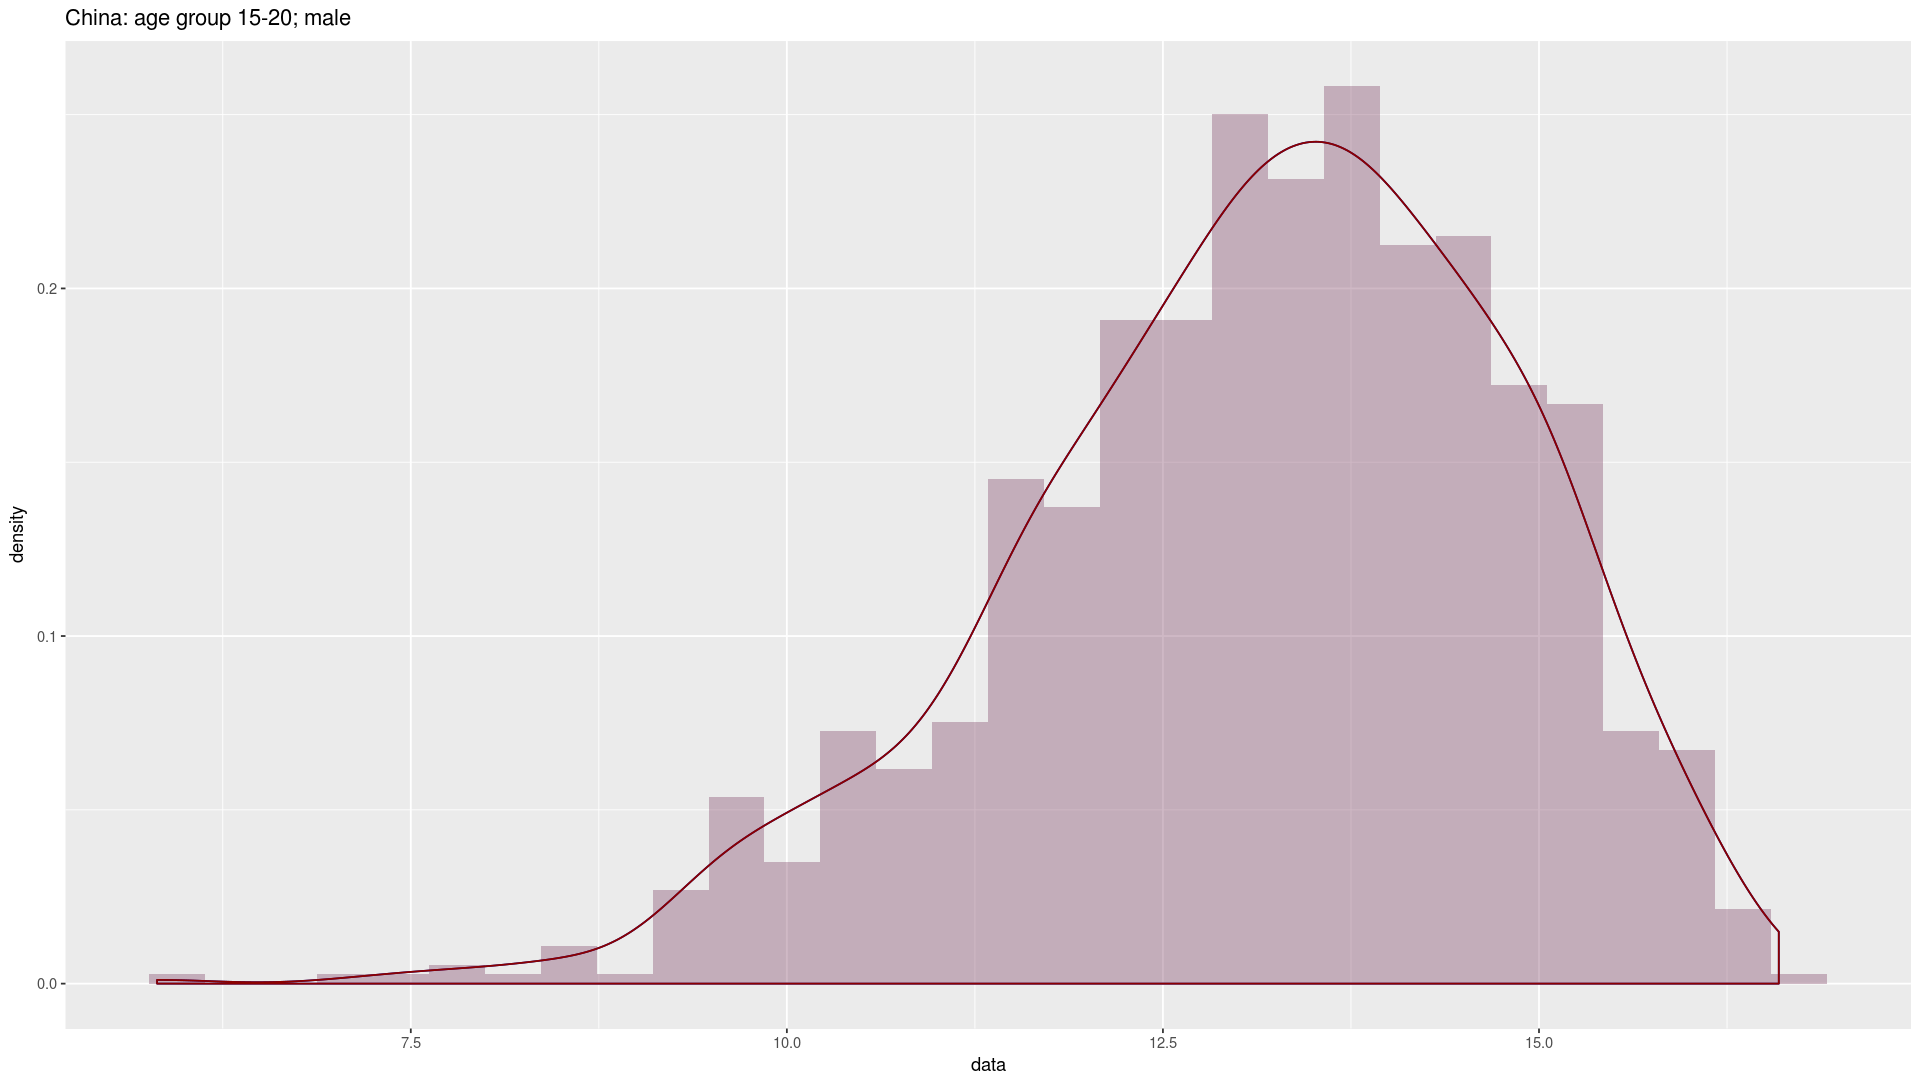

In [43]:
x1<-data.frame(myarray2["6","2040","15_1",]); colnames(x1) <- "data"
x2<-data.frame(myarray3["6","2040","15_1",]); colnames(x2) <- "data"

ggplot(data = x1, aes(x=data)) + 
    geom_histogram(aes(y=  ..density..), alpha=0.3, fill="steelblue") +
    geom_density(color ="blue4") +
geom_histogram(data = x1, aes(x=data, y=  ..density..), alpha=0.15, fill="red1") +
    geom_density(color ="red4")   + ggtitle("China: age group 15-20; male")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


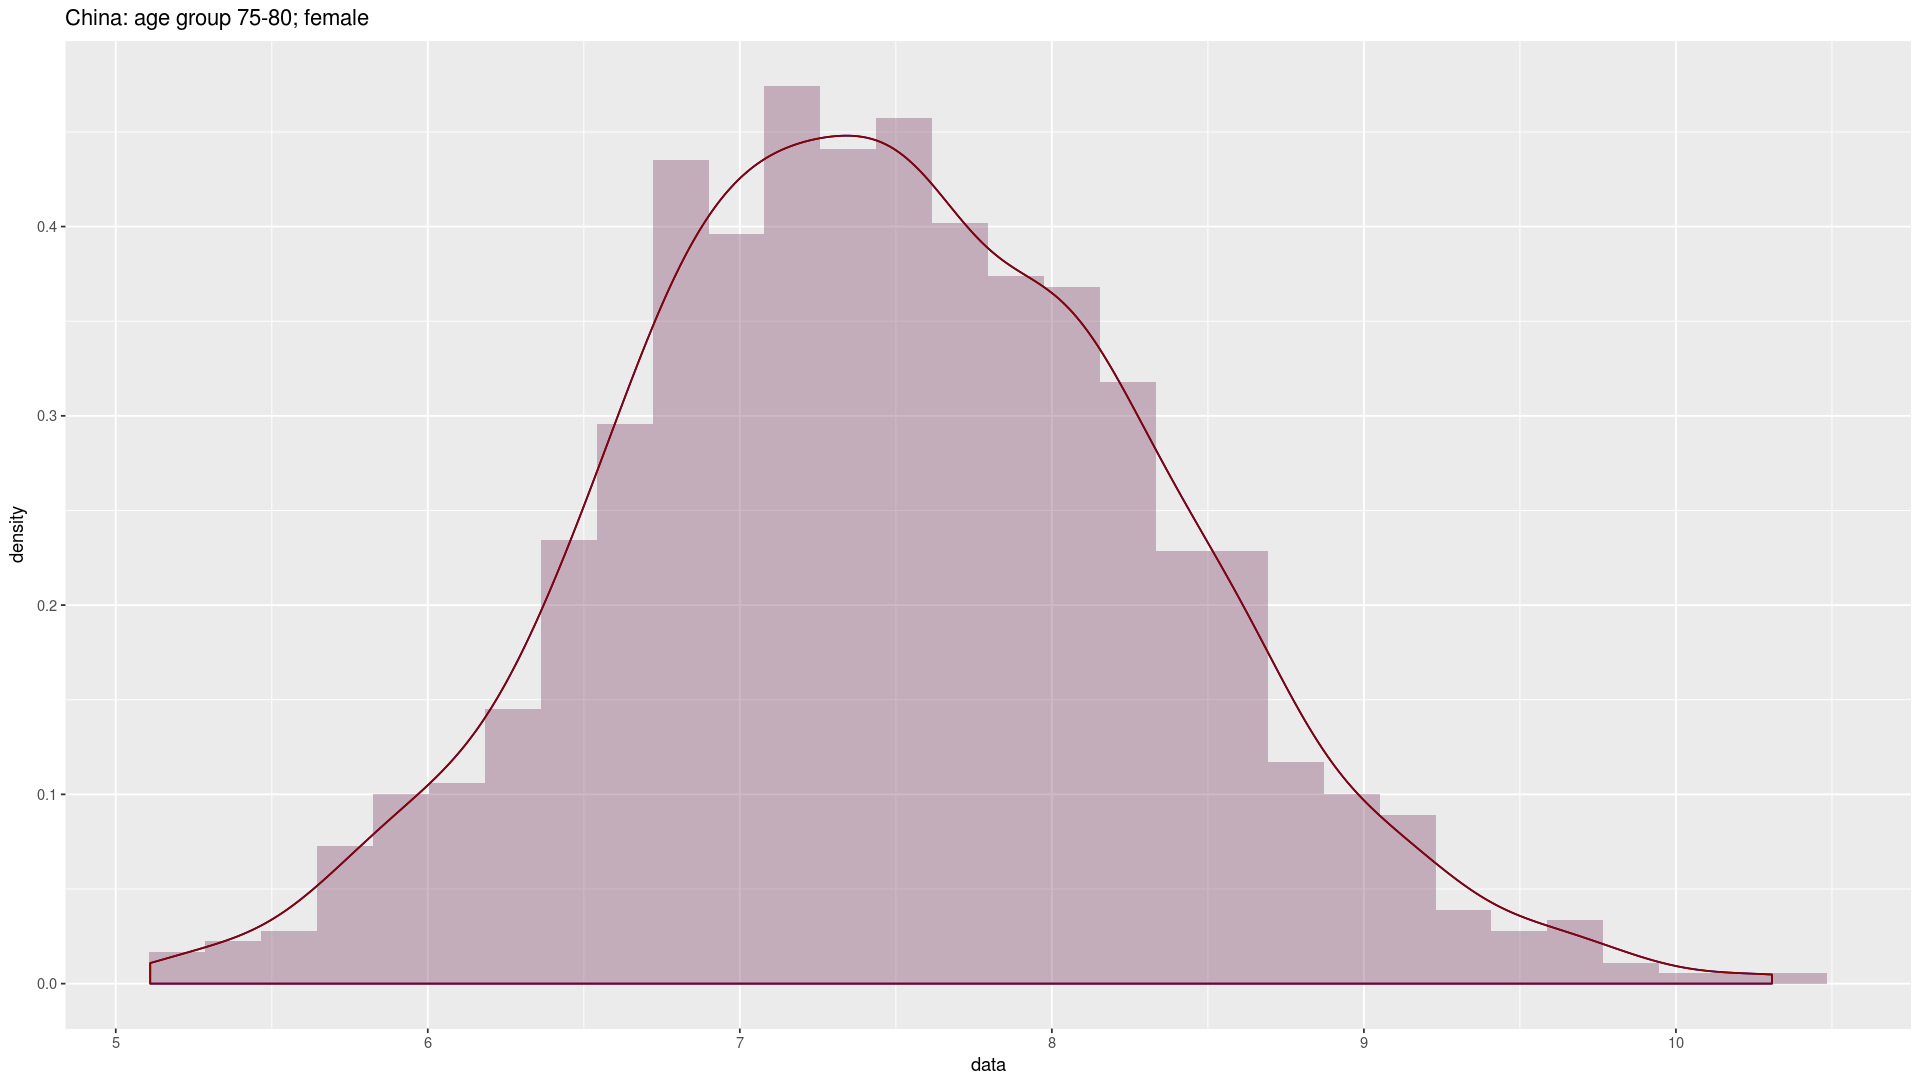

In [45]:
x1<-data.frame(myarray2["6","2040","75_2",]); colnames(x1) <- "data"
x2<-data.frame(myarray3["6","2040","75_2",]); colnames(x2) <- "data"

ggplot(data = x1, aes(x=data)) + 
    geom_histogram(aes(y=  ..density..), alpha=0.3, fill="steelblue") +
    geom_density(color ="blue4") +
geom_histogram(data = x1, aes(x=data, y=  ..density..), alpha=0.15, fill="red1") +
    geom_density(color ="red4") + ggtitle("China: age group 75-80; female")

In [28]:
## Turn the collapsed ones into arrays as well
array_Xcorr_df_CY <- melt(Xcorr_df_CY, id.vars = c("location_id", "year_id"), value.name = "edu", variable.name = "variable")
array_Xcorr_df_CY <- reshape2::acast(array_Xcorr_df_CY, location_id ~ year_id ~ variable, value.var = "edu")
str(array_Xcorr_df_CY) ### last 3 values are mean, upper, lower

array_uncorr_df_CY <- melt(uncorr_df_CY, id.vars = c("location_id", "year_id"), value.name = "edu", variable.name = "variable")
array_uncorr_df_CY <- reshape2::acast(array_uncorr_df_CY, location_id ~ year_id ~ variable, value.var = "edu")
str(array_uncorr_df_CY) ### last 3 values are mean, upper, lower

 num [1:191, 1:91, 1:1003] 2.43 2.72 3.84 1.47 1.9 ...
 - attr(*, "dimnames")=List of 3
  ..$ : chr [1:191] "6" "7" "8" "10" ...
  ..$ : chr [1:91] "1950" "1951" "1952" "1953" ...
  ..$ : chr [1:1003] "draw0" "draw1" "draw2" "draw3" ...


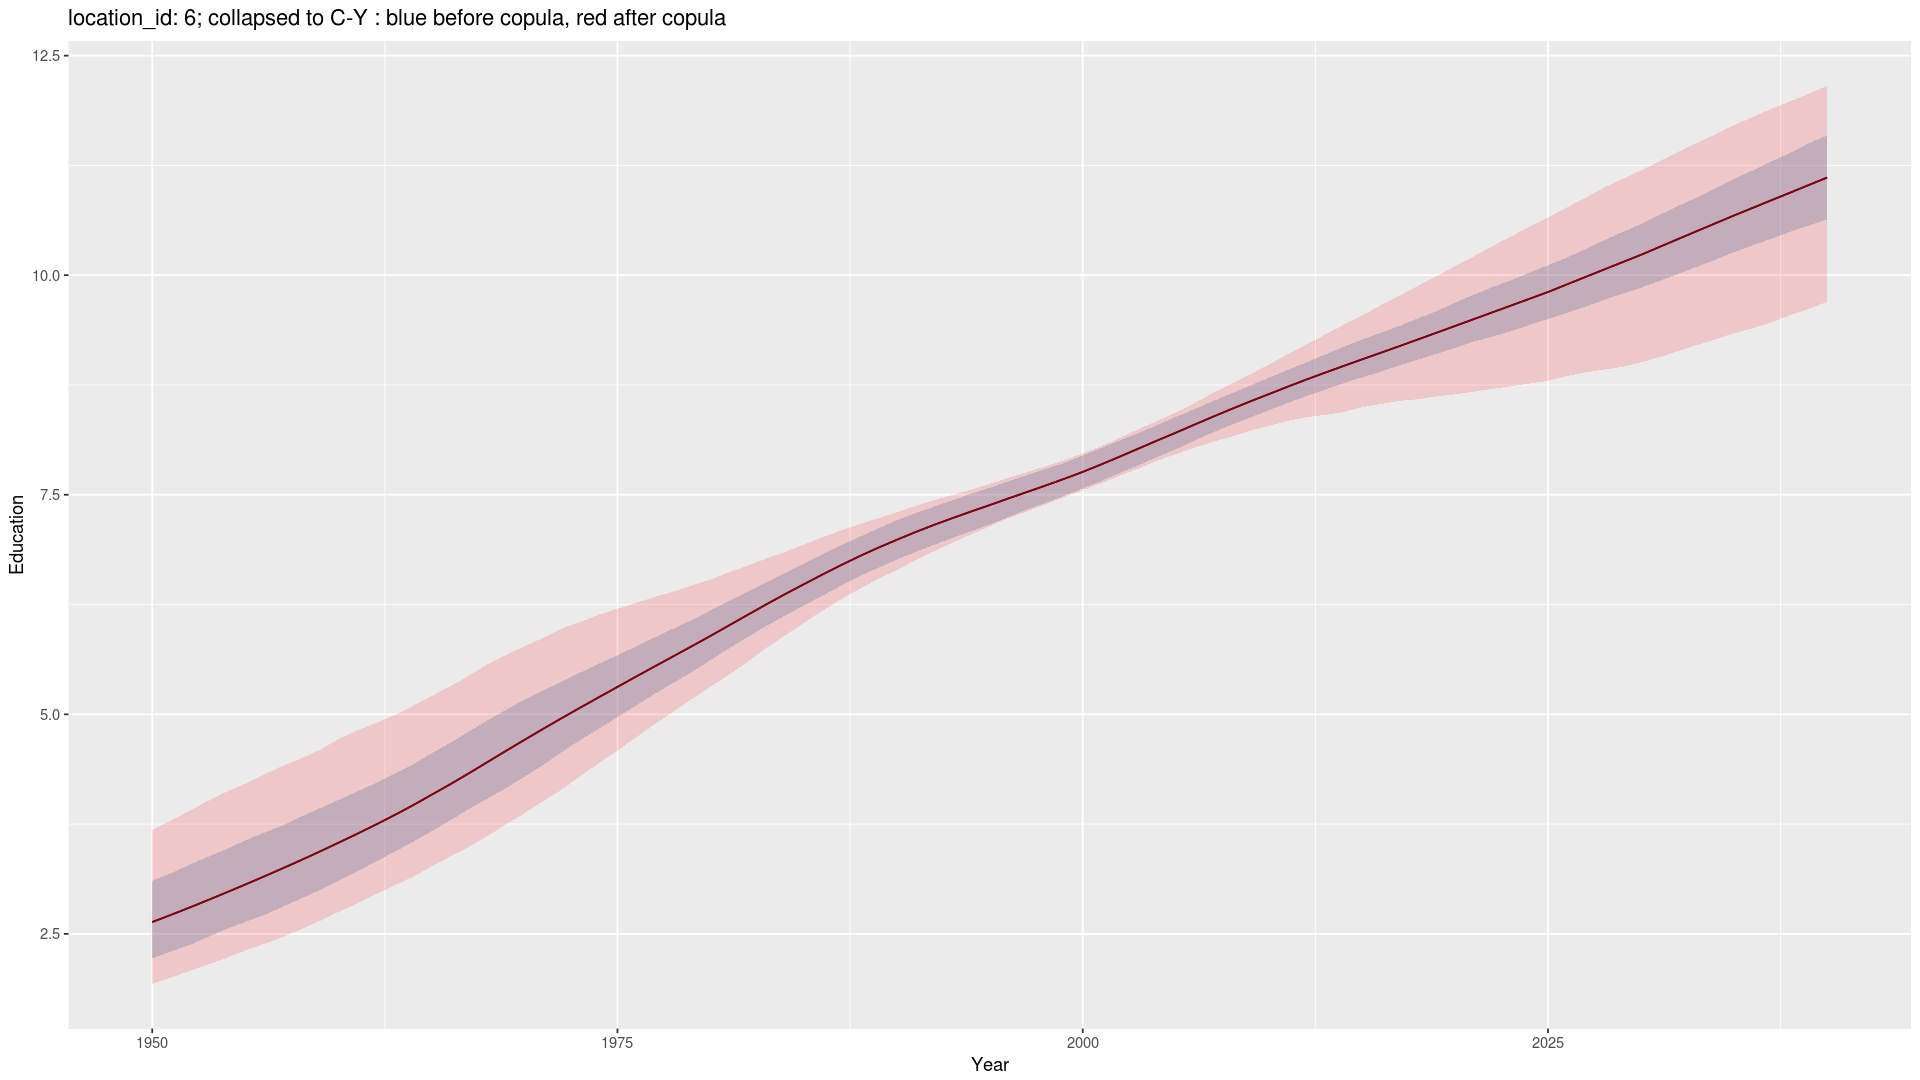

In [34]:
plot_country_collapsed<-function(loc_id) {
ggplot(uncorr_df_CY[location_id == loc_id,], aes(x = year_id, y = mean, ymin = lower, ymax = upper)) +
    geom_ribbon(alpha = 0.3, fill="steelblue") +
    geom_line(color = "blue4") +
    geom_ribbon(data=Xcorr_df_CY[location_id == loc_id,], aes(x = year_id, ymin = lower, ymax = upper),
                alpha = 0.15, fill="red1") +
    geom_line(aes(x=year_id, y=mean),color = "red4") + xlab("Year") + ylab("Education") +
    ggtitle(paste0("location_id: ", loc_id, "; collapsed to C-Y : blue before copula, red after copula"))
}

plot_country_collapsed(6)

In [46]:
## Save out data

# Collapsed C-Y
fwrite(Xcorr_df_CY, "/home/j/WORK/01_covariates/02_inputs/education/update_2017/data/output_data/20161121_GBD2016prelim_95+_raked_2/country_year_A_S_T_collapsed.csv")

### Make country-year plots

In [35]:
filename <- paste0("/homes/sadatnfs/test_edu.pdf")
pdf(filename, width=10, height = 6)
    for(c in countries){
        print(plot_country_collapsed(c))
    }
dev.off()

png 
  2